In [35]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
import os
import shutil

In [36]:
def plott(dfs, columns, sufixes, x='Number of env steps total'):
    if len(columns) > 2:
        fig, axs = plt.subplots(2,2)
        figsize = (15, 10)
    else:
        fig, axs = plt.subplots(1,2)
        figsize = (15, 5)

    for j, df in enumerate(dfs):
        if df is not None:
            for i, column in enumerate(columns):
                if len(columns) > 2:
                    axspos = axs[int(i/2), int(i%2)]
                else:
                    axspos = axs[i]
                df.plot.line(x=x, y=column, ax=axspos, figsize=figsize, title=column)
                axspos.legend([column + ' ' + sufix for sufix in sufixes if sufixes])

In [37]:
REMOVE_BELOW_STEPS = 100000
progresses = []
idx = 0

for dirname, _, filenames in os.walk('output'):
    for filename in filenames:
        if 'progress' in filename:
            file = os.path.join(dirname, filename)

            try:
                tempdf = pd.read_csv(file)
            except pd.errors.EmptyDataError as e:
                shutil.rmtree(dirname, ignore_errors=True)
                print('Removed empty folder', dirname)
                continue

            steps = tempdf['Number of env steps total'].iloc[-1]
            if steps < REMOVE_BELOW_STEPS:
                shutil.rmtree(dirname, ignore_errors=True)
                print('Removed small experiment (', steps, ' steps)', dirname)
                continue
                
            progresses.append(file)
            print(idx, steps, progresses[-1])
            idx += 1

0 1200000 output/cheetah-vel/2020_03_03_16_20_26/progress.csv
1 1540000 output/cheetah-vel/2020_02_17_18_09_55/progress.csv
2 1380000 output/cheetah-vel/2020_02_16_00_49_55/progress.csv
3 1117500 output/pick-place-ml1/2020_02_15_02_02_24/progress.csv
4 645000 output/pick-place-ml1/2020_03_04_01_00_28/progress.csv
5 1136250 output/pick-place-ml1/2020_02_15_02_00_11/progress.csv


In [38]:
results = [
    ('PEARL', pd.read_csv(progresses[0], skiprows=[1])),
    ('Intrinsic 1', pd.read_csv(progresses[1], skiprows=[1])),
    ('Intrinsic 2', pd.read_csv(progresses[2], skiprows=[1]))
]

for i, (label, df) in enumerate(results):
    if 'Mean Intrinsic Reward' in df.columns:
        label = 'Intrinsic'
        results[i] = (label, df)
    
    hours = '%.2f' % float(df['Total Train Time (s)'].iloc[-1] / 60 / 60)
    print('Results ' + str(i) + ' (' + label + '): ', df['Number of env steps total'].iloc[-1], ' steps in ', hours, 'hours')

Results 0 (PEARL):  1200000  steps in  8.55 hours
Results 1 (Intrinsic):  1540000  steps in  20.79 hours
Results 2 (Intrinsic):  1380000  steps in  36.74 hours


In [39]:
results[0][1].columns

Index(['Z mean train', 'Z variance train', 'KL Divergence', 'KL Loss',
       'QF Loss', 'VF Loss', 'Policy Loss', 'Q Predictions Mean',
       'Q Predictions Std', 'Q Predictions Max', 'Q Predictions Min',
       'V Predictions Mean', 'V Predictions Std', 'V Predictions Max',
       'V Predictions Min', 'Log Pis Mean', 'Log Pis Std', 'Log Pis Max',
       'Log Pis Min', 'Policy mu Mean', 'Policy mu Std', 'Policy mu Max',
       'Policy mu Min', 'Policy log std Mean', 'Policy log std Std',
       'Policy log std Max', 'Policy log std Min', 'Z mean eval',
       'Z variance eval', 'AverageTrainReturn_all_train_tasks',
       'AverageReturn_all_train_tasks', 'AverageReturn_all_test_tasks',
       'Number of train steps total', 'Number of env steps total',
       'Number of rollouts total', 'Train Time (s)',
       '(Previous) Eval Time (s)', 'Sample Time (s)', 'Epoch Time (s)',
       'Total Train Time (s)', 'Epoch'],
      dtype='object')

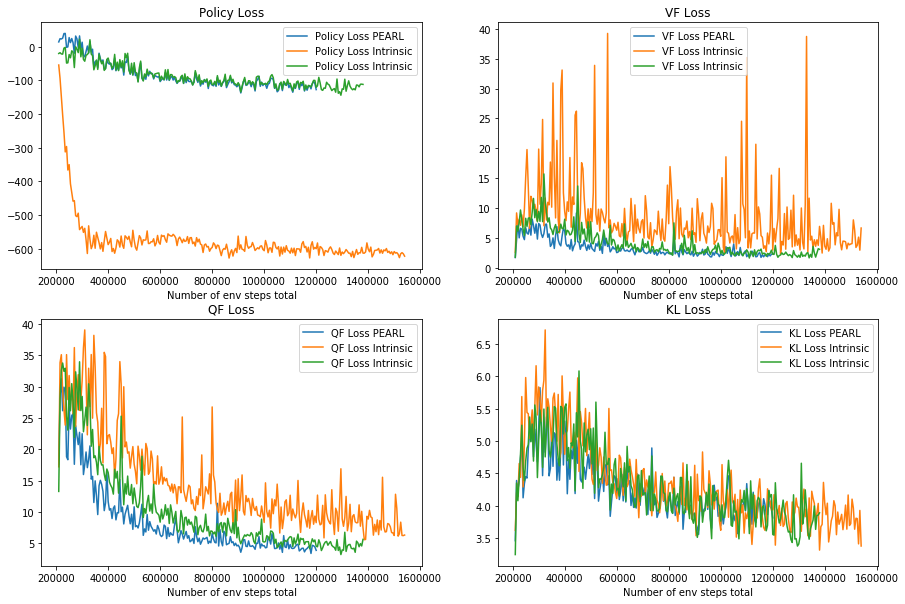

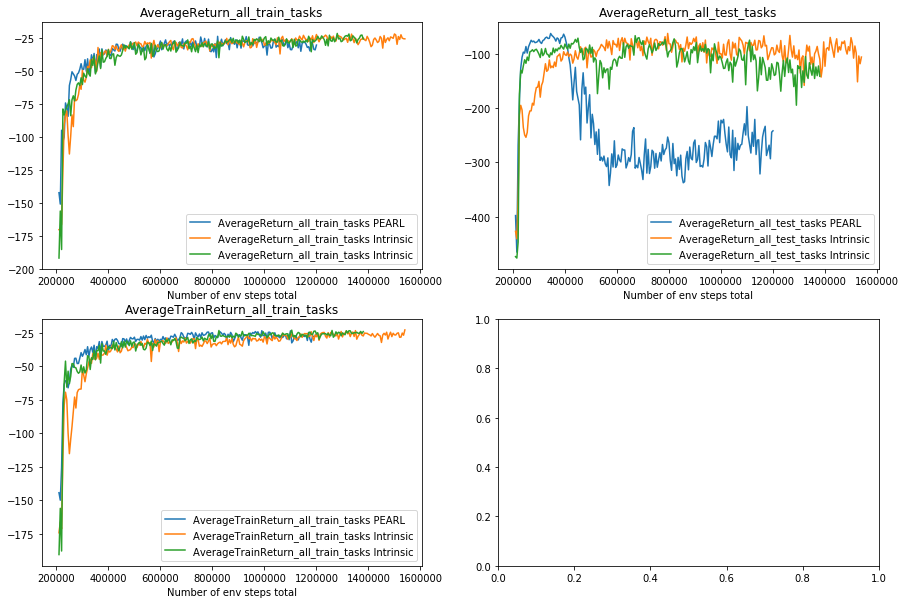

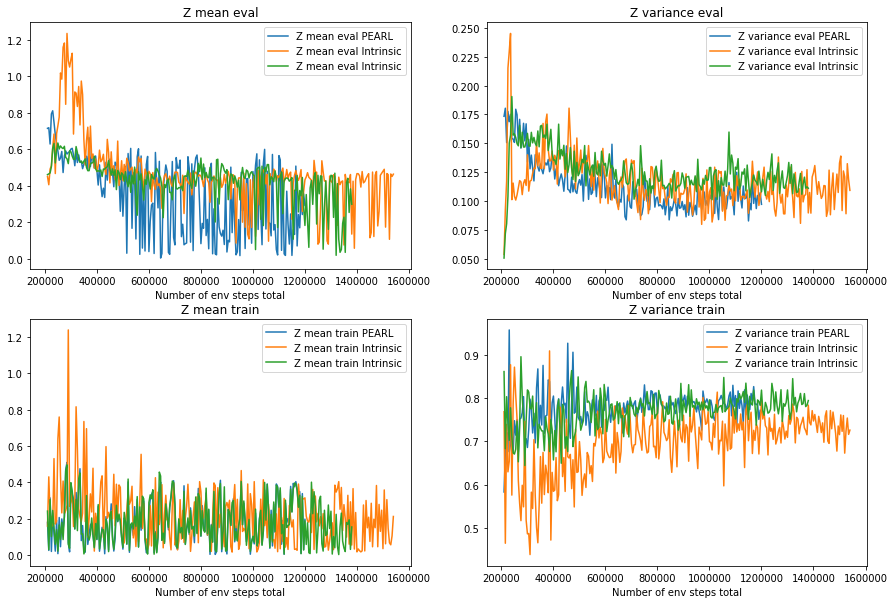

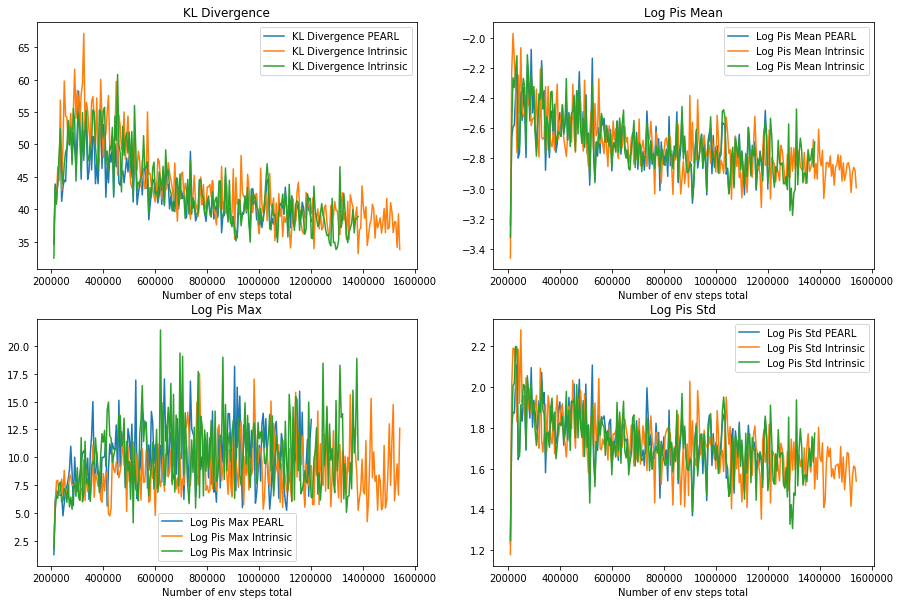

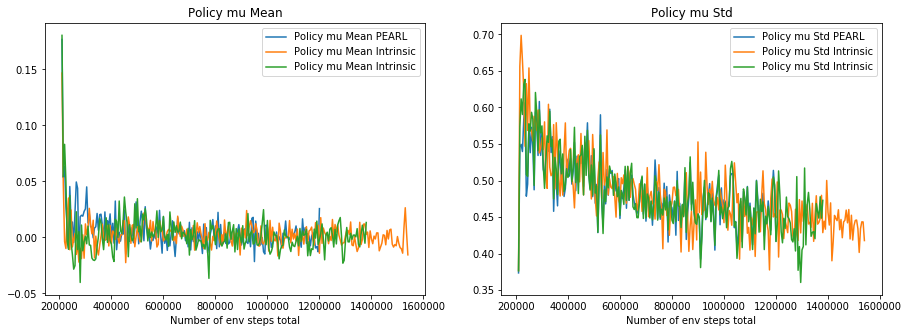

In [42]:
"""
if ('Decoder Loss' in results1.columns and 'Mean Intrinsic Reward' in results1.columns) or \
    (results2 is not None and 'Decoder Loss' in results2.columns and 'Mean Intrinsic Reward' in results2.columns):
    fig, axs = plt.subplots(1, 2)
if 'Decoder Loss' in results1.columns and 'Mean Intrinsic Reward' in results1.columns:
    results1.plot.line(x='Number of env steps total', y='Decoder Loss', ax=axs[0], figsize=(15, 5))
    results1.plot.line(x='Number of env steps total', y='Mean Intrinsic Reward', ax=axs[1])
if results2 is not None and 'Decoder Loss' in results2.columns and 'Mean Intrinsic Reward' in results2.columns:
    results2.plot.line(x='Number of env steps total', y='Decoder Loss', ax=axs[0], figsize=(15, 5))
    results2.plot.line(x='Number of env steps total', y='Mean Intrinsic Reward', ax=axs[1])
"""

dfs = [df for _, df in results]
labels = [label for label, _ in results]
plott(dfs, ['Policy Loss', 'VF Loss', 'QF Loss', 'KL Loss'], labels)
plott(dfs, ['AverageReturn_all_train_tasks', 'AverageReturn_all_test_tasks', 'AverageTrainReturn_all_train_tasks'], labels)
plott(dfs, ['Z mean eval', 'Z variance eval', 'Z mean train', 'Z variance train'], labels)
plott(dfs, ['KL Divergence', 'Log Pis Mean', 'Log Pis Max', 'Log Pis Std'], labels) # 'Latent Entropy'
plott(dfs, ['Policy mu Mean', 'Policy mu Std'], labels)